**Result generation script for the manuscript: *Quantum emitter in a plasmonic field: an orientation generalised model*, by Hapuarachchi et al.**
(This code is intended to run on Google Colab)

### **Notebook content:**
1. [Packages and constants used](#packages_and_constants)
2. [Utility functions](#Utility_functions)
3. [Differential-algebraic equation (DAE) system class](#DAESystem)
4. [ODE solver and callables for the extreme case solutions in the literature](#Lit_sol)
5. [Function to generate time domain verification and polar plots](#verification)
6. [Function to generate field magnitude and phase lag plots](#field_analysis)
7. [Results](#results)

### **1. Packages and constants used**<a name='packages_and_constants'></a>


In [ ]:
import time

import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
import cmath as cm

from scipy.integrate import solve_ivp
from scipy.interpolate import CubicSpline
from scipy.optimize import fsolve
from scipy.special import spherical_jn

from google.colab import files

c = sp.constants.c                          # speed of light
ec = sp.constants.e                         # elementary charge
h_bar = sp.constants.hbar                   # reduced planck constant
eps_0 = sp.constants.epsilon_0              # permittivity of free space
solve_ivp_method = 'RK45'                   # Differential solution method for solve_ivp()

### **2. Utility functions**<a name='Utility_functions'></a>

In [ ]:
"""
Outputs the plasmonic dielectric function using the refractive index (n) and extinction coefficient (k)
measurements in Johnson & Christy 1972, Phys. Rev. B 6, 4370.
Inputs:
metal     : 'Au' or 'Ag'
om_eV_vals: array of input optical energies  in eV
"""
def get_eps_JC(metal, om_eV_vals):

    omega_eV_JC = np.array([0.64,0.77,0.89,1.02,1.14,1.26,1.39,1.51,1.64,1.76,1.88,2.01,2.13,2.26,2.38,
    2.50,2.63,2.75,2.88,3.00,3.12,3.25,3.37,3.50,3.62,3.74,3.87,3.99,4.12,4.24,4.36,4.49,4.61,4.74,4.86,
    4.98,5.11,5.23,5.36,5.48,5.60,5.73,5.85, 5.98, 6.10,6.22,6.35,6.47, 6.60])

    if metal == 'Au':
        n = np.array([0.92, 0.56, 0.43, 0.35, 0.27, 0.22, 0.17, 0.16, 0.14, 0.13, 0.14,0.21, 0.29, 0.43, 0.62,
                        1.04, 1.31, 1.38, 1.45, 1.46, 1.47, 1.46, 1.48, 1.50, 1.48, 1.48, 1.54, 1.53, 1.53, 1.49,
                        1.47, 1.43, 1.38, 1.35, 1.33, 1.33, 1.32, 1.32, 1.30, 1.31, 1.30, 1.30, 1.30, 1.30, 1.33,
                        1.33, 1.34, 1.32, 1.28])

        k = np.array([13.78, 11.21, 9.519, 8.145, 7.150, 6.350, 5.663, 5.083, 4.542, 4.103, 3.697, 3.272, 2.863,
                        2.455, 2.081, 1.833, 1.849, 1.914, 1.948, 1.958, 1.952, 1.933, 1.895, 1.866, 1.871, 1.883,
                        1.898, 1.893, 1.889, 1.878, 1.869, 1.847, 1.803, 1.749, 1.688, 1.631, 1.577, 1.536, 1.497,
                        1.460, 1.427, 1.387, 1.350, 1.304, 1.277, 1.251, 1.226, 1.203, 1.188])

    if metal == 'Ag':
        n = np.array([0.24, 0.15, 0.13, 0.09, 0.04, 0.04, 0.04, 0.04, 0.03, 0.04, 0.05, 0.06, 0.05, 0.06,
                        0.05, 0.05, 0.05, 0.04, 0.04, 0.05, 0.05, 0.05, 0.07, 0.10, 0.14, 0.17, 0.81, 1.13,
                        1.34, 1.39, 1.41, 1.41, 1.38, 1.35, 1.33, 1.31, 1.30, 1.28, 1.28, 1.26, 1.25, 1.22,
                        1.20, 1.18, 1.15, 1.14, 1.12, 1.10, 1.07])

        k = np.array([14.08, 11.85, 10.10, 8.828, 7.795, 6.992, 6.312, 5.727, 5.242, 4.838, 4.483, 4.152,
                        3.858, 3.586, 3.324, 3.093, 2.869, 2.657, 2.462, 2.275, 2.070, 1.864, 1.657, 1.419,
                        1.142, 0.829, 0.392, 0.616, 0.964, 1.161, 1.264, 1.331, 1.372, 1.387, 1.393, 1.389,
                        1.378, 1.367, 1.357, 1.344, 1.342, 1.336, 1.325, 1.312, 1.296, 1.277, 1.255, 1.232, 1.212])

    n_cs = CubicSpline(omega_eV_JC, n)
    k_cs = CubicSpline(omega_eV_JC, k)

    Re_eps = n_cs(om_eV_vals)**2 - k_cs(om_eV_vals)**2
    Im_eps = 2 * n_cs(om_eV_vals) * k_cs(om_eV_vals)

    eps_JC = Re_eps + 1j*Im_eps

    return eps_JC




"""
Outputs the (4*pi excluded) plasmonic polarisability for a plasmonic nanoparticle
Inputs:
metal     : 'Au' or 'Ag'
r_m       : radius
eps_B     : permittivity of the background medium (assumed real)
om_eV_vals: array of input optical energies  in eV
"""
def get_alpha(metal, r_m, eps_B, om_eV_vals):

    eps_m = get_eps_JC(metal, om_eV_vals)
    BetaCM = (eps_m - eps_B) / (eps_m + 2 * eps_B)

    return (r_m**3) * BetaCM




"""
Outputs the optical screening factor experienced by the quantum emitter
epsQ: permittivity of the emitter material
epsB: permittivity of the background medium
"""
def get_screeningFac(epsQ, epsB):
    return (2*epsB + epsQ)/(3*epsB)




"""
Outputs the initial values of complex x and y components (cx, cy) of the exp(-i\omega t) coefficient of the
total field experienced by the quantum emitter
E0          : exp(-i\omega t) coefficient of the external input field
theta_rad   : electric polarisation of the external input field
screeningFac: field screening factor of the emitter material
alpha_val   : (4*pi excluded) plasmonic polarisability for a plasmonic nanoparticle at the input field energy
R           : emitter-plasmon centre separation
"""
def get_cx0_cy0(E0, theta_rad, screeningFac, alpha_val, R):
    cx0 = (E0*np.cos(theta_rad)/screeningFac) * (1 + 2*alpha_val/(R**3))
    cy0 = (E0*np.sin(theta_rad)/screeningFac) * (1 - alpha_val/(R**3))
    return cx0, cy0




"""
Outputs the coeffient of the self-feedback field component generated by the QE dipole
"""
def get_dq_coeff(alpha, epsB, R, screeningFac):
    dq_coeff = alpha / ((4*np.pi*eps_0*epsB) * (R**6) * (screeningFac**2))
    return dq_coeff




"""
Outputs the exp(-i\omega t) coeffient of the total screened field experienced by the QE
Inputs:
cx0       : Initial value of exp(-i\omega t) coeffient of the total screened field along x-direction (axial)
cy0       : Same as above, along y-direction (tangential)
dq_coeff  : coeffient of the self-feedback field component generated by the QE dipole
dq_xplus  : exp(-i\omega t) coeffient of the classically equivalent QE dipole component along x-direction
dq_yplus  : exp(-i\omega t) coeffient of the classically equivalent QE dipole component along y-direction
"""
def get_E_tot_tilde_plus(cx0, cy0, dq_coeff, dq_xplus, dq_yplus):
    E_tot_tilde_plus = np.array([cx0 + 4*dq_coeff*dq_xplus, cy0 + dq_coeff*dq_yplus])
    return E_tot_tilde_plus


### **3. Differential-algebraic equation (DAE) system class**<a name='DAESystem'></a>
Contains the solver function for the DAE system and the callable functions for solve_ivp() and fsolve() methods used therein.

In [ ]:
class DAESystem:

    # Constructor or initialiser function that creates a class instance
    # (Input variables have the same meaning as defined in the paper and above)
    def __init__(self, theta_rad, E0, r_m, mu, epsQ, epsB, T1, T2, R, metal, omega0, omega):

        # Parameters that define the system
        self.detuning = omega - omega0
        self.alpha_val = get_alpha(metal, r_m, epsB, omega*h_bar/ec)
        self.screeningFac = get_screeningFac(epsQ, epsB)
        self.T1 = T1
        self.T2 = T2
        self.mu = mu

        # Coeffient of the self-feedback field component generated by the QE dipole, and its real-imag decomposition
        self.dq_coeff = get_dq_coeff(self.alpha_val, epsB, R, self.screeningFac)
        self.d_R = np.real(self.dq_coeff)
        self.d_I = np.imag(self.dq_coeff)

        # Initial field coeffients, their real-imag decomposition and magnitude
        self.cx0, self.cy0 = get_cx0_cy0(E0, theta_rad, self.screeningFac, self.alpha_val, R)
        self.cx0_R = np.real(self.cx0)
        self.cx0_I = np.imag(self.cx0)
        self.cy0_R = np.real(self.cy0)
        self.cy0_I = np.imag(self.cy0)
        self.M0 = np.sqrt(np.abs(self.cx0)**2 + np.abs(self.cy0)**2)

        # Initialising field component guesses for fsolve() called inside the solve_ivp() callable
        self.cx_R = self.cx0_R
        self.cx_I = self.cx0_I
        self.cy_R = self.cy0_R
        self.cy_I = self.cy0_I
        self.M = self.M0


    # Callable function for fsolve()
    # (Input variables have the same meaning as defined in the paper and above)
    def equations_for_fsolve(self, vars, d_R, d_I, mu, cx0_R, cx0_I, cy0_R, cy0_I, A, B):

        cx_R, cx_I, cy_R, cy_I, M = vars  # Unpacking the variables

        # Equations (24a)-(24e) in paper with LHS set to zero
        eq_cx_R = cx0_R + (4*mu/M) * ((d_R*cx_R - d_I*cx_I)*A + (d_R*cx_I + d_I*cx_R)*B) - cx_R
        eq_cx_I = cx0_I + (4*mu/M) * ((d_R*cx_I + d_I*cx_R)*A - (d_R*cx_R - d_I*cx_I)*B) - cx_I
        eq_cy_R = cy0_R + (mu/M) * ((d_R*cy_R - d_I*cy_I)*A + (d_R*cy_I + d_I*cy_R)*B) - cy_R
        eq_cy_I = cy0_I + (mu/M) * ((d_R*cy_I + d_I*cy_R)*A - (d_R*cy_R - d_I*cy_I)*B) - cy_I
        eq_M = np.sqrt(cx_R**2 + cx_I**2 + cy_R**2 + cy_I**2) - M

        return [eq_cx_R, eq_cx_I, eq_cy_R, eq_cy_I, eq_M]


    # Callable function of solve_ivp()
    # (Input variables have the same meaning as defined in the paper and above)
    def coupled_ode_angle_gen(self, t, y):

        # Assign current iteration's y as A = y[0], B = y[1], Delta = y[2]
        A, B, Delta = y

        # Use fsolve with the additional arguments to find current values of field coeffients as initial guesses
        init_guesses = [self.cx_R, self.cx_I, self.cy_R, self.cy_I, self.M]
        arguments = (self.d_R, self.d_I, self.mu, self.cx0_R, self.cx0_I, self.cy0_R, self.cy0_I, A, B)
        cx_R, cx_I, cy_R, cy_I, M = fsolve(self.equations_for_fsolve, init_guesses, arguments)

        # assembling complex cx, cy
        cx = complex(cx_R, cx_I)
        cy = complex(cy_R, cy_I)

        # Create the linear Rabi component and decompose to real and imag (equation (18))
        Om = (self.mu/h_bar)*(self.cx0*cx.conjugate()+self.cy0*cy.conjugate())/M
        Om_Re = np.real(Om)
        Om_Im = np.imag(Om)

        # Create nonlinear Rabi component and decompose to real and imag (equation (18))
        eta = ((self.mu**2)/h_bar)*self.dq_coeff*(4*(np.abs(cx)**2)+(np.abs(cy)**2))/(M**2)

        eta_Re = np.real(eta)
        eta_Im = np.imag(eta)

        # Find the values of the differentials for the current variable values
        # (Equations (22a)-(22c))
        diff_A = (-(A/self.T2) + self.detuning*B - (Om_Im + eta_Im*A - eta_Re*B)*Delta)
        diff_B = (-(B/self.T2) - self.detuning*A - (Om_Re + eta_Re*A + eta_Im*B)*Delta)
        diff_Delta = ((1-Delta)/self.T1 + 4*(Om_Im*A + Om_Re*B + eta_Im*(A**2 + B**2)))

        # Updating instance variables (to use as initial guesses for fsolve() in the next iteration)
        self.cx_R = cx_R
        self.cx_I = cx_I
        self.cy_R = cy_R
        self.cy_I = cy_I
        self.M = M

        # Return the differential values of the current iteration
        return [diff_A, diff_B, diff_Delta]


    # The following function solves the set of differential-algebraic equations (22a)-(24e)
    # when called on a DAESystem class instance. Parameters have usual meanings as above and in the paper.
    def solve_DAE(self, t_span, y0, t_eval):

        # Solve the differential equations
        sol = solve_ivp(self.coupled_ode_angle_gen, t_span, y0, solve_ivp_method, t_eval)
        A_t = sol.y[0]
        B_t = sol.y[1]
        Delta_t = sol.y[2]

        # Reconstruct field evolution for the above A_t, B_t
        cx_t = []
        cy_t = []
        M_t = []
        init_guesses = [self.cx0_R, self.cx0_I, self.cy0_R, self.cy0_I, self.M0]
        for idx in range(len(t_eval)):
            arguments = (self.d_R, self.d_I, self.mu, self.cx0_R, self.cx0_I, self.cy0_R, self.cy0_I, A_t[idx], B_t[idx])
            cx_R, cx_I, cy_R, cy_I, M = fsolve(self.equations_for_fsolve, init_guesses, arguments)
            init_guesses = [cx_R, cx_I, cy_R, cy_I, M] # update local init_guesses list for next iteration
            cx_t.append(complex(cx_R, cx_I))
            cy_t.append(complex(cy_R, cy_I))
            M_t.append(M)

        return np.array(A_t), np.array(B_t), np.array(Delta_t), np.array(cx_t), np.array(cy_t), np.array(M_t)

### **4. ODE solver and callables for the extreme case solutions in the literature**<a name='Lit_sol'></a>

In [ ]:
# Callable function for solve_ivp() to use in the extreme case solutions
# (Input variables have the same meaning as defined in the paper and above)
def coupled_ode_extreme(t, y, T1, T2, detuning, Om_Re, Om_Im, eta_Re, eta_Im):
    A, B, Delta = y  # Assign current iteration's y as A = y[0], B = y[1], Delta = y[2]

    # Find the values of the differentials (using the diff eqs. to be solved), given the current A, B, Delta (i.e, y)
    diff_A = -(A/T2) + detuning*B - (Om_Im + eta_Im*A - eta_Re*B)*Delta
    diff_B = -(B/T2) - detuning*A - (Om_Re + eta_Re*A + eta_Im*B)*Delta
    diff_Delta = (1-Delta)/T1 + 4*(Om_Im*A + Om_Re*B + eta_Im*(A**2 + B**2))

    # Return the differential values of the current iteration
    return [diff_A, diff_B, diff_Delta]



# Returns A, B, Delta, & E_plus (exp(-i\omega t) coefficient of total field) temporal lists for the extreme case solutions established in the literature
# Setting s_a or alpha = 0 gives solutions for the isolated emitter
# (Input variables have the same meaning as defined in the paper and above)
def get_extreme_sol(s_a, E0, r_m, mu, epsQ, epsB, T1, T2, R, metal, omega0, omega, t_span, y0, solve_ivp_method, t_eval):

    detuning = omega - omega0
    alpha_val = get_alpha(metal, r_m, epsB, omega*h_bar/ec)
    screeningFac = get_screeningFac(epsQ, epsB)

    # ---> Generate extreme case solutions
    Om = (mu*E0/(h_bar*screeningFac)) * (1 + s_a*alpha_val/(R**3))  # From equation (25a)
    Om_Re = np.real(Om)
    Om_Im = np.imag(Om)

    eta = ((s_a**2) *  (mu**2) * alpha_val )/( (4*np.pi*eps_0*epsB) * (R**6) * h_bar * (screeningFac**2)) # From equation (25b)
    eta_Re = np.real(eta)
    eta_Im = np.imag(eta)

    sol_Lit = solve_ivp(coupled_ode_extreme, t_span, y0, method=solve_ivp_method, t_eval=t_eval,
                        args=(T1, T2, detuning, Om_Re, Om_Im, eta_Re, eta_Im))

    A = sol_Lit.y[0]
    B = sol_Lit.y[1]
    Delta = sol_Lit.y[2]
    E_plus = (h_bar/mu)*(Om + (A-1j*B)*eta)

    return A, B, Delta, E_plus  # Returns A, B, Delta, E_plus temporal lists

### **5. Function to generate time domain verification and polar plots**<a name='verification'></a>

In [ ]:
'''
This function outputs time domain verification plots (against extreme case solutions in the literature)
and polar plots for the variation of steady state values.

Inputs:
Set iter_var_name to 'E0' or 'r_m' to iterate over different driving field coefficients or plasmonic radii.
'iter_var_list' is the list of E0 or r_m values to iterate over
'iter_var_strs' is the list of plot legend strings for each iteration variable value
Other input variables have the same meanings as defined in the paper and above
'''
def verification_and_polar_plots(E0, r_m, mu, epsQ, epsB, T1, T2, R, metal, omega0, omega, num_theta_points,
                               iter_var_name, iter_var_list, iter_var_strs,
                                plot_rho_verifications=True, plot_field_verifications=True, saveFigs=True):

    if plot_rho_verifications:
        # Figures for temporal verification
        fig_t, ax_t = plt.subplots(2, 2, figsize=(9.5,6))
        fig_t.subplots_adjust(wspace=0.25, hspace=0.4)

    if plot_field_verifications:
        # Figure for field verification
        fig_f, ax_f = plt.subplots(1, 2, figsize=(10,5))
        fig_f.subplots_adjust(bottom=0.3, wspace=0.4)

    # Figure for the polar plots
    fig_p, ax_p = plt.subplots(subplot_kw={'projection': 'polar'}, figsize=(8, 5))
    ax_p.set_rlabel_position(0)  # radial labels along 0 degrees
    fig_p.tight_layout()


    # Color selection for figures
    cols = ['#b3c6ff', '#4d79ff', '#002080']

    # Creating the list of angles in degrees such that both 0 and 90 are included
    # (to extract for the verification temporal plots).
    # All angles should be converted to radians using the function np.deg2rad()
    theta_degrees_part1 = np.linspace(0, 90, num_theta_points // 4 + 1, endpoint=False)  # // is floor division
    theta_degrees_part2 = np.linspace(90, 360, 3 * num_theta_points // 4)
    theta_degrees_list = np.concatenate((theta_degrees_part1, theta_degrees_part2))

    # Time
    t_span = (1e-15, 100e-9)
    t_eval = np.logspace(np.log10(t_span[0]), np.log10(t_span[1]), 1000)

    # Initial conditions for solve_ivp
    y0 = np.array([0.,0.,1.], dtype=float)  # A, B, Delta

    for idx, var in enumerate(iter_var_list):
        start_time = time.time()

        if iter_var_name=='E0':
            E0 = var
        if iter_var_name=='r_m':
            r_m = var

        # Initialising lists to hold steady state values
        A_ss = [];     B_ss = [];     Delta_ss = []

        for theta_deg in theta_degrees_list:

            # Initialise a DAESystem class instance and solve for system of equations for the current theta_deg value
            dae_system = DAESystem(np.deg2rad(theta_deg), E0, r_m, mu, epsQ, epsB, T1, T2, R, metal, omega0, omega)
            A_t, B_t, Delta_t, cx_t, cy_t, M_t = dae_system.solve_DAE(t_span, y0, t_eval)

            # Extracting the steady state values from time domain solutions
            A_ss.append(A_t[-1])
            B_ss.append(B_t[-1])
            Delta_ss.append(Delta_t[-1])

            # Verification plots against extreme case solutions in literature
            # Creating a lower resolution time array for verification points
            t_eval_lit = np.logspace(np.log10(t_span[0]), np.log10(t_span[1]), 50)
            if theta_deg == 0 or theta_deg == 90:

                if theta_deg == 0: s_a = 2; axIdx = 0
                if theta_deg == 90: s_a = -1; axIdx = 1

                [A_t_lit, B_t_lit, Delta_t_lit, E_plus_lit] = get_extreme_sol(s_a, E0, r_m, mu, epsQ, epsB, T1, T2, R,
                                                    metal, omega0, omega, t_span, y0, solve_ivp_method, t_eval_lit)

                if plot_rho_verifications:
                    ax_t[axIdx][0].plot(t_eval_lit, np.real(1-Delta_t_lit)/2, 'k.', markersize=5)
                    ax_t[axIdx][0].plot(t_eval, np.real(1-Delta_t)/2, color=cols[idx],
                                        label = iter_var_name + '='+ iter_var_strs[idx])

                    ax_t[axIdx][1].plot(t_eval_lit, np.abs(A_t_lit+1j*B_t_lit), 'k.', markersize=5)
                    ax_t[axIdx][1].plot(t_eval, np.abs(A_t+1j*B_t), color=cols[idx],
                                       label = iter_var_name + '='+ iter_var_strs[idx])

                    if idx==0:
                        ax_t[axIdx][0].set_ylabel(r'$\rho_{ee}, \theta=$' + f'{theta_deg:.0f}' + r'$^0$')
                        ax_t[axIdx][1].set_ylabel(r'$|\rho_{ge}|, \theta=$' + f'{theta_deg:.0f}' + r'$^0$')


                if plot_field_verifications:
                    ax_f[axIdx].plot(t_eval_lit, np.abs(E_plus_lit), 'k.', markersize=5)
                    ax_f[axIdx].plot(t_eval, M_t, color=cols[idx])


        # Solving for isolated isotropic QE & extracting steady state values (a single value for A, B, Delta each)
        s_a = 0
        r_m = 0
        [_, _, Delta_t_iso, _] = get_extreme_sol(s_a, E0, r_m, mu, epsQ, epsB, T1, T2, R,
                                                    metal, omega0, omega, t_span, y0, solve_ivp_method, t_eval_lit)

        Delta_ss_iso = Delta_t_iso[-1]

        # Plotting rho_ee (with and without plasmonic influence) on the polar plot
        ax_p.plot(np.deg2rad(theta_degrees_list), (1-np.array(Delta_ss))/2,
                         color=cols[idx], label = r'$\rho_{ee}$, ' + iter_var_name + '='+ iter_var_strs[idx])
        ax_p.plot(np.deg2rad(theta_degrees_list), np.ones(len(theta_degrees_list))*(1-Delta_ss_iso)/2,
                         color=cols[idx], ls='--', lw='0.75')
        ax_p.legend(bbox_to_anchor=(1.05, 0.85), frameon=False)

        print('Time taken : ' + str((time.time()-start_time)/60) + ' minutes')
        #pdb.set_trace()


    if plot_rho_verifications:
        fig_t.suptitle(r'Verification of $\rho$')
        ax_t[0][0].legend(frameon=False)
        for i in [0,1]:
            for j in [0,1]:
                ax_t[i][j].set_xscale('log'); ax_t[i][j].set_xlabel('Time (s)'); ax_t[i][j].set_xlim(1e-13,1e-7)

    if plot_field_verifications:
        fig_f.suptitle('|Field coefficient|')
        ax_f[0].set_xscale('log'); ax_t[i][j].set_xlabel('Time (s)'); ax_t[i][j].set_xlim(1e-13,1e-7)
        ax_f[1].set_xscale('log'); ax_t[i][j].set_xlabel('Time (s)'); ax_t[i][j].set_xlim(1e-13,1e-7)


    if saveFigs:
        det_mueV = (1e6)*(omega - omega0)*h_bar/ec

        if plot_rho_verifications:
            save_str = iter_var_name + f'_det_{det_mueV:.2f}eV_rho_verification'
            fig_t.savefig(save_str + '.pdf', bbox_inches='tight')
            files.download(save_str + '.pdf')

        if plot_field_verifications:
            save_str = iter_var_name + f'_det_{det_mueV:.2f}eV_field_verification'
            fig_f.savefig(save_str + '.pdf', bbox_inches='tight')
            files.download(save_str + '.pdf')

        save_str_p = iter_var_name + f'_det_{det_mueV:.2f}eV_polar'
        fig_p.savefig(save_str_p + '.pdf', bbox_inches='tight')
        files.download(save_str_p + '.pdf')

### **6. Function to generate field magnitude and phase lag plots**<a name='field_analysis'></a>

In [ ]:
'''
This function generates the magnitude and phase variation plots for mutually perpendicular components of the field amplitude

Inputs:
Normaliser  : component magnitudes plotted are normalised by this value
times       : Time points to plot markers at
c_L         : complex amplitude component to plot on the left y axis
c_R         : complex amplitude component to plot on the right y axis
c_L_str     : Label string for the left y axis
c_L_str     : Label string for the right y axis
'''
def plot_field_components(Normaliser, times, c_L, c_R, c_L_str, c_R_str, saveFigs=True, save_str=''):

    # Generating interpolating functions and denser timepoints for the lineplots
    c_L_cs = CubicSpline(times, c_L)
    c_R_cs = CubicSpline(times, c_R)
    interp_t = np.linspace(times[0], times[-1], 500)

    fig, ax = plt.subplots(2, 1, figsize=(5,4.0))
    fig.subplots_adjust(left=0.2, right=0.7, top=0.9, bottom=0.2, hspace=0.5)

    # ---> Plotting magnitude of c_x relative to E0_iso
    ax[0].plot(times*1e9, np.abs(c_L)/Normaliser, 'r*', alpha = 0.6, ms=9)
    ax[0].plot(interp_t*1e9, np.abs(c_L_cs(interp_t))/Normaliser, 'r-')
    ax[0].set_ylabel('|c'+ c_L_str +'| (norm.)', color='r');  ax[0].set_xlabel('Time (s)')
    ax[0].tick_params(axis='y', colors='red')

     # ---> Plotting magnitude of c_y relative to E0_iso on twinned axis
    ax_y0 = ax[0].twinx()
    ax_y0.plot(times*1e9, np.abs(c_R)/Normaliser, 'b.',ms=5)
    ax_y0.plot(interp_t*1e9, np.abs(c_R_cs(interp_t))/Normaliser, 'b:')
    ax_y0.tick_params(axis='y', color='blue', labelcolor='blue')
    ax_y0.set_ylabel('|c'+ c_R_str +'| (norm.)', color='b');  ax[0].set_xlabel('Time (s)')
    ax_y0.spines['right'].set_color('blue')
    ax_y0.spines['left'].set_color('red')  # As twinx() creates axis spines on top of ax[0] left spine is colored here
    ax_y0.set_xlim(times[0]*1e9, times[-1]*1e9)

    # Extracting the phases for marker plots of phases
    theta_L = np.angle(c_L, deg=True)
    theta_R = np.angle(c_R, deg=True)

    # Extracting the phases for interpolated line plots of phases
    theta_L_cs = np.angle(c_L_cs(interp_t), deg=True)
    theta_R_cs = np.angle(c_R_cs(interp_t), deg=True)

    # Generating phase plots for c_L
    ax[1].plot(times*1e9, theta_L, 'r*', alpha = 0.6, ms=9)
    ax[1].plot(interp_t*1e9, theta_L_cs, 'r-')
    ax[1].tick_params(axis='y', colors='red')
    ax[1].set_ylabel(r'$\theta$' + c_L_str, color='r');  ax[1].set_xlabel('Time (ns)')

    # Generating phase plots for c_R on twinned axis
    ax_y1 = ax[1].twinx()
    ax_y1.plot(times*1e9, theta_R, 'b.',ms=5)
    ax_y1.plot(interp_t*1e9, theta_R_cs, 'b:')
    ax_y1.tick_params(axis='y', color='blue', labelcolor='blue')
    ax_y1.set_ylabel(r'$\theta$' + c_R_str, color='b');  ax[0].set_xlabel('Time (ns)')
    ax_y1.spines['right'].set_color('blue')
    ax_y1.spines['left'].set_color('red')  # as twinx() creates axis spines on top of ax[0] left spine is colored here
    ax_y1.set_xlim(times[0]*1e9, times[-1]*1e9)

    if saveFigs:
        from google.colab import files
        plt.savefig(save_str + '.pdf', bbox_inches='tight')
        files.download(save_str + '.pdf')

### **7. Results**<a name='results'></a>

In [ ]:
E0 = 3e4                # exp(-i\omega t) coefficient of the external input field
mu = (0.2e-9)*ec        # transition dipole element
epsQ = 6.0              # Quantum emitter material permittivity
epsB = 1.0              # Submerging medium: air
T1 = .8e-9              # Relaxation time
T2 = .3e-9              # Coherence time
R = 25e-9               # Emitter-MNP centre separation
r_m = 15e-9             # Plasmonic particle radius
metal = 'Au'            # Plasmonic particle type
num_theta_points = 200  # Number of points in polar plot

saveFigs = False

Setting emitter resonance frequency at the plasmonic peak

In [ ]:
om_eV_vals = np.linspace(1.75, 3.25, 1000)
alpha_max = get_alpha(metal, r_m, epsB, om_eV_vals)
maxIdx = np.argmax(np.abs(alpha_max))
res_eV = om_eV_vals[maxIdx]

omega0 = res_eV*ec/h_bar    # converting emitter resonance from eV to rad/s
print('TLA resonance is selected to be equal to the plasmonic resonance: ' + f'{res_eV:.3f} eV')

TLA resonance is selected to be equal to the plasmonic resonance: 2.355 eV


### **Plasmonic radius variation polar and verification plots**

In [ ]:
r_m_list = np.array([15e-9, 17.5e-9, 20e-9])
r_m_str_list = ['15nm', '17.5nm', '20nm']

iter_var_name = 'r_m'
iter_var_list = r_m_list
iter_var_strs = r_m_str_list

**Polar plot of excited state populations for an external field perfectly resonant with the QE:**

Time taken : 1.9818308313687643 minutes
Time taken : 2.017759664853414 minutes
Time taken : 2.4619070291519165 minutes


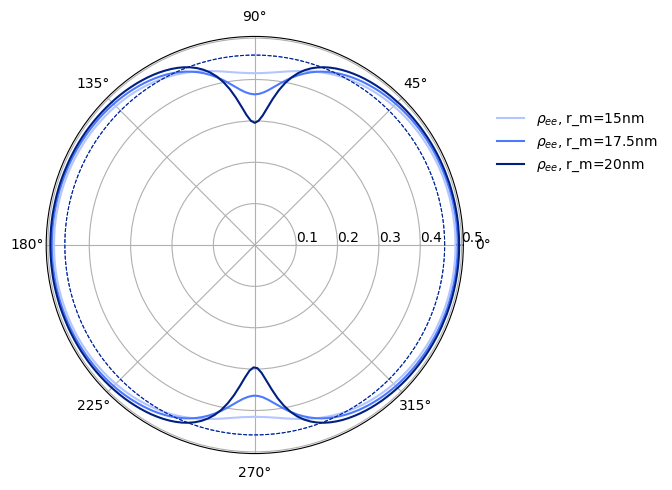

In [ ]:
omega = omega0
verification_and_polar_plots(E0, r_m, mu, epsQ, epsB, T1, T2, R, metal, omega0, omega, num_theta_points,
                            iter_var_name, iter_var_list, iter_var_strs,
                            plot_rho_verifications=False, plot_field_verifications=False, saveFigs=saveFigs);

**Polar plot of excited state populations for an external field detuned from the QE:** Detuning = +20$\mu eV$

Time taken : 5.901710681120554 minutes
Time taken : 6.005073245366415 minutes
Time taken : 6.262657662232717 minutes


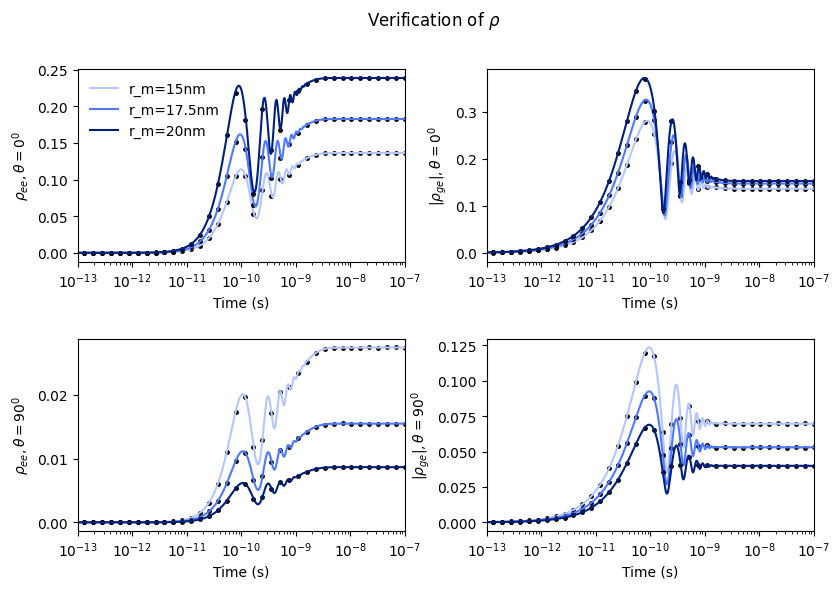

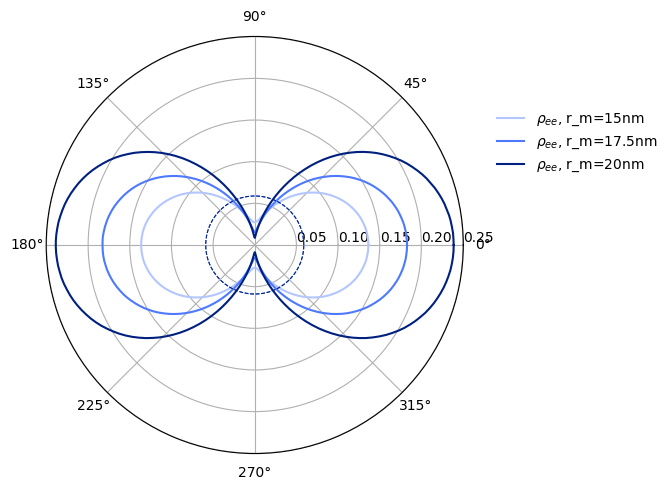

In [ ]:
omega = omega0 + (20e-6)*ec/h_bar
verification_and_polar_plots(E0, r_m, mu, epsQ, epsB, T1, T2, R, metal, omega0, omega, num_theta_points,
                            iter_var_name, iter_var_list, iter_var_strs,
                            plot_rho_verifications=True, plot_field_verifications=False, saveFigs=saveFigs);

**Field evolution plots**

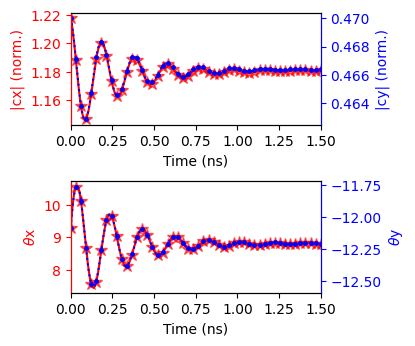

In [ ]:
t_span = (0, 1.5e-9)
t_eval = np.linspace(t_span[0], t_span[-1], 50)
y0 = np.array([0., 0., 1.], dtype = float)  # Initial conditions [A, B, Delta]
E0_iso = E0/get_screeningFac(epsQ, epsB)    # Screened external field experienced by the isolated QE

theta_deg = 45                              # Polarisation angle considered

dae_system = DAESystem(np.deg2rad(theta_deg), E0, r_m, mu, epsQ, epsB, T1, T2, R, metal, omega0, omega)
A_t, B_t, Delta_t, cx_t, cy_t, M_t = dae_system.solve_DAE(t_span, y0, t_eval)

plot_field_components(E0_iso, t_eval, cx_t, cy_t, 'x', 'y', saveFigs=saveFigs, save_str='Field_for_45_deg');